In [17]:
import numpy as np
import os
from os.path import isfile

import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, ZeroPadding2D, GlobalAveragePooling2D

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

#### Define global paths

In [18]:
DATA_DIR = '/Users/james/Documents/Data/genre classification/' 
AUDIO_DIR = DATA_DIR + 'Audio' 
NPZ_DIR = DATA_DIR + 'npz'

In [19]:
# folder to save model results
if not os.path.exists('./models/cnn_basic'):
    os.makedirs('./models/cnn_basic')

#### load

In [20]:
npzfile = np.load(NPZ_DIR + '/shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(2024, 640, 128) (2024, 2)


In [21]:
npzfile = np.load(NPZ_DIR + '/shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(579, 640, 128) (579, 2)


#### genre look-up (based off of genre_target variable in data_transformer

In [22]:
dict_genre_targets = {'Club': 0, 'bass-other': 1}
reverse_genre_dict = {j:i for i, j in dict_genre_targets.items()}
print(reverse_genre_dict)

{0: 'Club', 1: 'bass-other'}


### CNN Basic Model

In [38]:
BATCH_SIZE = 32
EPOCH_COUNT = 70
L2_regularization = 0.001

In [39]:
def cnn_model_basic(input_shape, num_classes):
    
    model = Sequential()

    model.add(ZeroPadding2D(padding=2, data_format="channels_first", input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', data_format="channels_first"))
    model.add(ZeroPadding2D(padding=2, data_format="channels_first"))
    model.add(Conv2D(32, (3, 3), data_format="channels_first", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))
    model.add(Dropout(0.25))

    model.add(ZeroPadding2D(padding=2, data_format="channels_first"))
    model.add(Conv2D(64, (3, 3), data_format="channels_first", activation='relu'))
    model.add(ZeroPadding2D(padding=2, data_format="channels_first"))
    model.add(Conv2D(64, (3, 3), data_format="channels_first", activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), data_format="channels_first"))
    model.add(Dropout(0.25))

    model.add(ZeroPadding2D(padding=2, data_format="channels_first"))
    model.add(Conv2D(128, (3, 3), data_format="channels_first", activation='relu'))
    model.add(ZeroPadding2D(padding=2, data_format="channels_first"))
    model.add(Conv2D(128, (3, 3), data_format="channels_first", activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), data_format="channels_first"))
    model.add(Dropout(0.25))

    model.add(ZeroPadding2D(padding=2, data_format="channels_first"))
    model.add(Conv2D(256, (3, 3), activation='relu', data_format="channels_first"))
    model.add(ZeroPadding2D(padding=2, data_format="channels_first"))
    model.add(Conv2D(256, (3, 3), activation='relu', data_format="channels_first"))
    model.add(GlobalAveragePooling2D(data_format="channels_first"))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    print(model.summary)

    return model

In [49]:
def train_model(x_train, y_train, x_val, y_val):
    
    num_classes = len(np.unique(y_train))
    
    n_frequency = 128
    n_frames = 640
    
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
#    model_input = Input(input_shape, name='input')
    
    model = cnn_model_basic(input_shape, num_classes)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/cnn_basic/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [50]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [51]:
# run
model, history = train_model(X_train, y_train, X_valid, y_valid)

W0709 23:05:23.453456 4355683776 deprecation.py:323] From /Users/james/Documents/Virtual Environments/deep-audio-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x14630fd68>>
Training...
Train on 2024 samples, validate on 579 samples
Epoch 1/70
2024/2024 [==============================] - 24s 12ms/step - loss: 0.6955 - acc: 0.5084 - val_loss: 0.6927 - val_acc: 0.5216

Epoch 00001: val_acc improved from -inf to 0.52159, saving model to ./models/cnn_basic/weights.best.h5
Epoch 2/70
2024/2024 [==============================] - 23s 12ms/step - loss: 0.6926 - acc: 0.5242 - val_loss: 0.6922 - val_acc: 0.5216

Epoch 00002: val_acc did not improve from 0.52159
Epoch 3/70
2024/2024 [==============================] - 23s 11ms/step - loss: 0.6923 - acc: 0.5242 - val_loss: 0.6923 - val_acc: 0.5216

Epoch 00003: val_acc did not improve from 0.52159
Epoch 4/70
2024/2024 [==============================] - 23s 11ms/step - loss: 0.6923 - acc: 0.5242 - val_loss: 0.6922 - val_acc: 0.5216

Epoch 00004: val_acc did not improve from 0.52159
Epoch 5/70
2024/2024 [=========================

2024/2024 [==============================] - 25s 12ms/step - loss: 0.6922 - acc: 0.5242 - val_loss: 0.6922 - val_acc: 0.5216

Epoch 00042: val_acc did not improve from 0.52159
Epoch 43/70
2024/2024 [==============================] - 24s 12ms/step - loss: 0.6920 - acc: 0.5242 - val_loss: 0.6922 - val_acc: 0.5216

Epoch 00043: val_acc did not improve from 0.52159
Epoch 44/70
2024/2024 [==============================] - 24s 12ms/step - loss: 0.6922 - acc: 0.5242 - val_loss: 0.6922 - val_acc: 0.5216

Epoch 00044: val_acc did not improve from 0.52159
Epoch 45/70
2024/2024 [==============================] - 25s 12ms/step - loss: 0.6925 - acc: 0.5242 - val_loss: 0.6922 - val_acc: 0.5216

Epoch 00045: val_acc did not improve from 0.52159
Epoch 46/70
2024/2024 [==============================] - 27s 13ms/step - loss: 0.6925 - acc: 0.5242 - val_loss: 0.6922 - val_acc: 0.5216

Epoch 00046: val_acc did not improve from 0.52159
Epoch 47/70
2024/2024 [==============================] - 25s 13ms/step -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


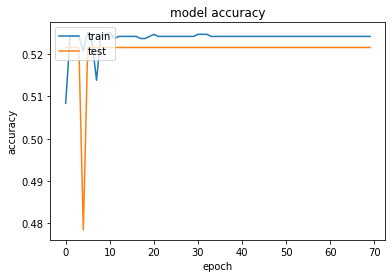

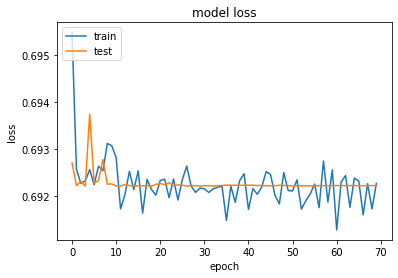

In [52]:
show_summary_stats(history)